In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import display
from scipy.stats import pearsonr
import seaborn as sns
from scipy.optimize import nnls  # for non-negative least squares
from scipy.stats import linregress
import matplotlib.patches as mpatches
import statsmodels.api as sm

rc('mathtext', default='regular')

from fun_LR_hydro_memory import *

# === Paths ===
root = '/Users/cag/Dropbox/0_Research/A_Fondecyts/2024_CAG_Ini_11240924/fdcyt_cag_GW_analysis/Analysis_cag_mid'
# out_figs = root + '/2_GW_memory'
out_figs = root + '/2_GW_memory_pred_pos'

if not os.path.exists(out_figs):
    os.makedirs(out_figs)

# === Global parameters ===
train_start = "1960-01-01"
train_end   = "2025-12-31"
min_obs = 100
r2_min = 0.4

# === Control for overwriting the prediction CSV on first write ===
predictions_file = f"{out_figs}/gw_predicted_all.csv"
overwrite_predictions = True  # Will be set to False after first write


# === Load data ===
gw_an_all = pd.read_csv(root + '/data/gw_wo_p_et_series_combined/wells_gw_an.csv', parse_dates=['date'])
pr_an_all = pd.read_csv(root + '/data/gw_wo_p_et_series_combined/wells_pr_an.csv', parse_dates=['date'])
codes = [col for col in gw_an_all.columns if col != 'date']

# === Lag config for computing predictors ===
pred_configs = [
    {"n_pred_max":10, "lag_type": 1, "lag_increase": 4, "model_config": 'type1_incr4_pred10_max'},
    {"n_pred_max":6,  "lag_type": 1, "lag_increase": 4, "model_config": 'type1_incr4_pred6_max'},
    {"n_pred_max":6,  "lag_type": 1, "lag_increase": 5, "model_config": 'type1_incr5_pred6_max'},
    {"n_pred_max":6,  "lag_type": 1, "lag_increase": 6, "model_config": 'type1_incr6_pred6_max'},
    {"n_pred_max":6,  "lag_type": 2, "lag_increase": 4, "model_config": 'type2_incr4_pred6_max'},
    {"n_pred_max":6,  "lag_type": 2, "lag_increase": 5, "model_config": 'type2_incr5_pred6_max'},
    {"n_pred_max":6,  "lag_type": 2, "lag_increase": 6, "model_config": 'type2_incr6_pred6_max'},
    {"n_pred_max":6,  "lag_type": 3, "lag_increase": 2, "model_config": 'type3_incr2_pred6_max'},
 
    # {"n_pred_max":6,  "lag_type": 3, "lag_increase": 3, "model_config": 'type3_incr3_pred6_max'}
]


# === Functions ===
def compute_r2(y1, y2):
    if y1 is None or y2 is None:
        return np.nan
    try:
        mask = y1.notna() & y2.notna()
        if np.std(y2[mask]) == 0 or np.std(y1[mask]) == 0:
            return np.nan
        return np.corrcoef(y1[mask], y2[mask])[0, 1]**2
    except Exception:
        return np.nan
    
    


def fit_ols_and_predict(X_df, y_series, min_obs=100, restrict_positive=False):
    """
    Fit regression model without intercept and predict over the full range of y.

    Returns:
        coef (np.ndarray or None), y_pred_full (pd.Series or None)
    """
    # align and drop rows where either y or any predictor is NaN (for fitting)
    df = pd.concat([y_series, X_df], axis=1).dropna()
    if len(df) < min_obs:
        return None, None  # <-- return TWO values consistently

    y_train = df.iloc[:, 0].values
    X_train = df.iloc[:, 1:].values
    if X_train.size == 0:
        return None, None

    # Fit model
    if restrict_positive:
        coef, _ = nnls(X_train, y_train)
    else:
        coef, _, _, _ = np.linalg.lstsq(X_train, y_train, rcond=None)

    # Predict over full y index wherever predictors are available
    y_pred_full = pd.Series(index=y_series.index, dtype=float)
    X_pred = X_df.reindex(y_series.index).dropna()
    if not X_pred.empty:
        y_pred_full.loc[X_pred.index] = X_pred.values @ coef
    else:
        # if no prediction rows available, signal no prediction
        return coef, None

    return coef, y_pred_full



# ========================== RUN THROUGH WELLS ============================

# Dataframes for storing LR results & gwl, precip and et for all wells (one column per well)

r2_summary_all = pd.DataFrame()

wells_pr_all = pd.DataFrame()
wells_et_all = pd.DataFrame()
wells_gw_all = pd.DataFrame()

# for cod in ['03450005','05731003', '05410014']:
# for cod in ['03451008','01700105','03450005','05731003', '05410014']: 
# for cod in ['05730033']: 
for cod in codes:
    gw_an = pd.Series(gw_an_all[cod].values, index=gw_an_all['date'])  # Added: define 'gw'
    if gw_an.notna().sum() < min_obs:
        continue  # Skip well
    pr_an = pd.Series(pr_an_all[cod].values, index=pr_an_all['date'])

    
    for config in pred_configs:
        n_pred_max = config["n_pred_max"]
        lag_type = config["lag_type"]
        lag_increase = config["lag_increase"]
        model_config_label = config["model_config"]

        # === Precheck at n_pred_max ===
        lag_type_label_max = f"type{lag_type}_incr{lag_increase}_pred{n_pred_max}"
        lag_ranges, widths, incr_name = make_lag_ranges(
            lag_increase=lag_increase,
            n_windows=n_pred_max,
            incr_type=lag_type
        )

        pred_memory = next(reversed(lag_ranges.values()))[1] + 1
        pred_pr_an = rolling_predictors(pr_an, lag_ranges, standardize=True)
        y = pd.Series(gw_an, name='gw_an', index=gw_an.index)
        
        coef, y_pred_full = fit_ols_and_predict(pred_pr_an, 
                                                y,
                                                min_obs=min_obs, 
                                                restrict_positive=True)

        if coef is None or y_pred_full is None:
            # print(f"⛔️ Skipping {model_config_label}: model fitting failed at n_pred_max")
            continue

        r2_check = compute_r2(y, y_pred_full)

        if pd.isna(r2_check) or r2_check < r2_min:
            # print(f"⛔️ Skipping {model_config_label}: R² = {r2_check:.2f} < {r2_min}")
            continue

        # Save prediction at n_pred_max (only if passed check)
        pred_out = pd.DataFrame({
            "date": y.index,
            "well_id": str(cod),
            "lag_type": lag_type_label_max,
            "model_config": model_config_label,
            "target_val": y.values,
            "pred": y_pred_full.values
        })
        pred_out.to_csv(
            predictions_file,
            mode='w' if overwrite_predictions else 'a',
            header=overwrite_predictions,
            index=False
        )
        overwrite_predictions = False

        # === Now run full loop from n_pred_max to 1 ===
        for n_pred in range(n_pred_max, 0, -1):
            lag_type_label = f"type{lag_type}_incr{lag_increase}_pred{n_pred}"
            lag_ranges, widths, incr_name = make_lag_ranges(
                lag_increase=lag_increase,
                n_windows=n_pred,
                incr_type=lag_type
            )

            pred_memory = next(reversed(lag_ranges.values()))[1] + 1
            pred_pr_an = rolling_predictors(pr_an, lag_ranges, standardize=True)
            y = pd.Series(gw_an, name='gw_an', index=gw_an.index)
            coef, y_pred_full = fit_ols_and_predict(pred_pr_an, y,min_obs=min_obs, restrict_positive=True)

            if coef is None or y_pred_full is None:
                continue

            r2_all = compute_r2(y, y_pred_full)
            has_neg = np.nan if coef is None else (coef < 0).any()

            r2_summary_all = pd.concat([
                r2_summary_all,
                pd.DataFrame([{
                    "well_id": str(cod),
                    "target": "gw_an",
                    "predictor": "pr_an",
                    "lag_type": lag_type_label,
                    "lag_incr_rule": incr_name,
                    "lag_incr": lag_increase,
                    "n_pred": n_pred,
                    "pred_memory": pred_memory,
                    "r2": r2_all,
                    "has_neg_coef": has_neg,
                    "model_config": model_config_label
                }])
            ], ignore_index=True)
    
r2_summary_all.to_csv(f"{out_figs}/r2_summary_all.csv", index=False, mode='w') 
print("\nLR models Finished! \nFinito! \nTerminado!\n")


LR models Finished! 
Finito! 
Terminado!



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import UnivariateSpline, PchipInterpolator
from sklearn.isotonic import IsotonicRegression

# === Define the updated compute_memory_from_spline_variants ===
def compute_memory_from_spline_variants(df_config, perc_max_r2=0.9, spline_smoothing=0.5):
    df_sub = df_config[df_config['n_pred'] <= 6].dropna(subset=['pred_memory', 'r2'])
    if len(df_sub) < 4:
        return {
            'memory_spline': np.nan,
            'memory_pchip': np.nan,
            'memory_iso': np.nan,
            'x_vals': None,
            'y_spline': None,
            'y_pchip': None,
            'y_iso': None
        }

    x = df_sub['pred_memory'].values
    y = df_sub['r2'].values
    sorted_idx = np.argsort(x)
    x_sorted = x[sorted_idx]
    y_sorted = y[sorted_idx]
    x_dense = np.linspace(x_sorted.min(), x_sorted.max(), 500)
    r2_target = perc_max_r2 * y_sorted.max()

    def find_threshold_crossing(x_vals, y_vals, threshold):
        above = y_vals >= threshold
        return x_vals[above][0] if np.any(above) else np.nan

    # Spline
    try:
        spline = UnivariateSpline(x_sorted, y_sorted, s=spline_smoothing)
        y_spline = spline(x_dense)
        mem_spline = find_threshold_crossing(x_dense, y_spline, r2_target)
    except Exception:
        y_spline = None
        mem_spline = np.nan

    # # PCHIP
    # try:
    #     pchip = PchipInterpolator(x_sorted, y_sorted)
    #     y_pchip = pchip(x_dense)
    #     mem_pchip = find_threshold_crossing(x_dense, y_pchip, r2_target)
    # except Exception:
    #     y_pchip = None
    #     mem_pchip = np.nan

    # Isotonic
    try:
        iso = IsotonicRegression(increasing=True)
        y_iso = iso.fit_transform(x_sorted, y_sorted)
        iso_dense = IsotonicRegression(increasing=True)
        y_iso_dense = iso_dense.fit_transform(x_sorted, y_sorted)
        y_iso_dense_vals = np.interp(x_dense, x_sorted, y_iso_dense)
        mem_iso = find_threshold_crossing(x_dense, y_iso_dense_vals, r2_target)
    except Exception:
        y_iso_dense_vals = None
        mem_iso = np.nan

    return {
        'memory_spline': mem_spline,
        'memory_iso': mem_iso,
        'x_vals': x_dense,
        'y_spline': y_spline,
        # 'y_pchip': y_pchip,
        'y_iso': y_iso_dense_vals
    }


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import gridspec

# === Load R2 results ===
root = '/Users/cag/Dropbox/0_Research/A_Fondecyts/2024_CAG_Ini_11240924/fdcyt_cag_GW_analysis/Analysis_cag_mid'
out_figs = root + '/2_GW_memory_pred_pos'

print('Results will be saved here: ' + out_figs)
df = pd.read_csv(f"{out_figs}/r2_summary_all.csv", dtype={"well_id": str})
# df = df[df['well_id'] == '05730033']

# === Load predictions ===
predictions_file = f"{out_figs}/gw_predicted_all.csv"
df_pred = pd.read_csv(predictions_file, parse_dates=["date"], dtype={"well_id": str})

# === Output ===
out_dir = out_figs + '/memory_per_well'
os.makedirs(out_dir, exist_ok=True)

# === Model configurations and colors ===
model_configs = {}
for name in df['model_config'].unique():
    subset = df[df['model_config'] == name].iloc[0]
    lt = int(name.split('_')[0].replace('type', ''))
    li = int(name.split('_')[1].replace('incr', ''))
    npmax = subset['n_pred'] if 'n_pred' in subset else df[df['model_config'] == name]['n_pred'].max()
    model_configs[name] = (lt, li, int(npmax))


# Fixed order for consistent coloring
ordered_model_configs = list(model_configs.keys())
color_palette = plt.get_cmap('tab10')
model_colors = {
    name: color_palette(i % 10)
    for i, name in enumerate(ordered_model_configs)
}

# only selected models with 6 predictors to avoid overfitting and misinterpreting results
selected_configs = [
    # {"n_pred_max":10, "lag_type": 1, "lag_increase": 4, "model_config": 'type1_incr4_pred10_max'},
    {"n_pred_max":6,  "lag_type": 1, "lag_increase": 4, "model_config": 'type1_incr4_pred6_max'},
    {"n_pred_max":6,  "lag_type": 1, "lag_increase": 5, "model_config": 'type1_incr5_pred6_max'},
    {"n_pred_max":6,  "lag_type": 1, "lag_increase": 6, "model_config": 'type1_incr6_pred6_max'},
    {"n_pred_max":6,  "lag_type": 2, "lag_increase": 4, "model_config": 'type2_incr4_pred6_max'},
    {"n_pred_max":6,  "lag_type": 2, "lag_increase": 5, "model_config": 'type2_incr5_pred6_max'},
    {"n_pred_max":6,  "lag_type": 2, "lag_increase": 6, "model_config": 'type2_incr6_pred6_max'},
    # {"n_pred_max":6,  "lag_type": 3, "lag_increase": 2, "model_config": 'type3_incr2_pred6_max'},
 
    # {"n_pred_max":6,  "lag_type": 3, "lag_increase": 3, "model_config": 'type3_incr3_pred6_max'}
]

selected_labels = [c["model_config"] for c in selected_configs]

memory_summary = []

# === Plot per well ===
for well in df['well_id'].unique():
    well_data = df[df['well_id'] == well]
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    fig = plt.figure(figsize=(13, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2])  # left panel wider
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    
    # Left plot: Observed vs predicted time series
    pred_data = df_pred[df_pred['well_id'] == well]

    for name in sorted(well_data['model_config'].unique()):
        color = model_colors.get(name, 'gray')
        pred_subset = pred_data[pred_data['model_config'] == name]
        if pred_subset.empty:
            continue

        if name == "type1_incr4_pred10_max":
            # Highlight this one in background, blue, thicker
            ax1.plot(
                pred_subset['date'], pred_subset['pred'],
                label=f'{name}',
                color='blue',
                linestyle='-',
                linewidth=1.5,
                zorder=0   # put it behind others
            )
        else:
            color = model_colors.get(name, 'gray')
            ax1.plot(
                pred_subset['date'], pred_subset['pred'],
                label=f'{name}',
                color=color,
                linestyle='-',
                linewidth=1,
                zorder=1
            )
            
        # ax1.plot(pred_subset['date'], pred_subset['pred'], label=f'{name}', color=color, linestyle='-', linewidth=1, zorder=1)
        # Plot observed values (without label so it's not included in the legend)
    ax1.scatter(pred_subset['date'], pred_subset['target_val'], color='black', s=6, zorder=2)  # 's' is marker size
    ax1.set_title(f"Well {well} – Time Series", loc='left')
    ax1.set_xlabel("Date")
    ax1.set_ylabel("GW anom (m)")
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Add legend only if prediction lines exist
    handles, labels = ax1.get_legend_handles_labels()
    if labels:
        ax1.legend(fontsize=8)

    # Right plot: R² vs memory
    for name in sorted(well_data['model_config'].unique()):
        if name not in model_configs:
            continue
        lt, li, npmax = model_configs[name]
        lag_type_str = f'type{lt}_incr{li}'
        valid_models = [f'{lag_type_str}_pred{n}' for n in range(1, npmax + 1)]
        subset = well_data[well_data['lag_type'].isin(valid_models)].sort_values('n_pred')
        
        if subset.empty:
            continue

        model_type = subset['lag_incr_rule'].unique()[0]
        label =  f"{model_type}, incr = {li}"
        color = model_colors.get(name, 'gray')

        ax2.plot(
            subset['pred_memory'], subset['r2'],
            label=label, marker='o', linestyle='None', color=color
        )

    # from your_module import compute_memory_from_spline_variants  # Replace with actual function import
    fit_results = compute_memory_from_spline_variants(
        well_data[well_data['model_config'].isin(selected_labels)]
    )
    
    # === Get max R² from selected model configs
    subset_selected = well_data[well_data['model_config'].isin(selected_labels)]
    max_r2_selected = subset_selected['r2'].max() if not subset_selected.empty else np.nan

    
    # === Store memory results if at least one is valid ===
    if any([
        # fit_results.get('memory_spline') is not None and not np.isnan(fit_results['memory_spline']),
        fit_results.get('memory_iso') is not None and not np.isnan(fit_results['memory_iso']),
    ]):
        memory_summary.append({
            'well_id': well,
            # 'memory_spline': fit_results.get('memory_spline'),
            'memory_iso': fit_results.get('memory_iso'),
            'max_r2_selected_configs': max_r2_selected
        })


    if fit_results['x_vals'] is not None:
        # if fit_results['y_spline'] is not None:
        #     ax2.plot(fit_results['x_vals'], fit_results['y_spline'], '--', color='black', alpha=.9, label='Spline fit')
        #     ax2.axvline(fit_results['memory_spline'], color='black', linestyle='-', linewidth=1)

        if fit_results['y_iso'] is not None:
            ax2.plot(fit_results['x_vals'], fit_results['y_iso'], '--', color='blue', alpha=0.9, label='fitted curve')
            ax2.axvline(fit_results['memory_iso'], color='blue', linestyle='-', linewidth=1)

    ax2.set_title("R² vs Predictor Memory", loc='left')
    ax2.set_xlabel("Predictor Memory (months)")
    ax2.set_ylabel("R²")
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.legend(fontsize=8)
    ax2.set_xlim(df['pred_memory'].min() - 5, df['pred_memory'].max() + 5)
    ax2.set_ylim(0, 1)

    # plt.tight_layout()
    # plt.show()
    
    plt.savefig(f"{out_dir}/ts&memory_{well}.pdf", bbox_inches='tight')
    plt.close()


df_memory_summary = pd.DataFrame(memory_summary)
df_memory_summary.to_csv(f"{out_figs}/memory_summary_curve.csv", index=False)
print("\nLR models Finished! \nFinito! \nTerminado!\n")

Results will be saved here: /Users/cag/Dropbox/0_Research/A_Fondecyts/2024_CAG_Ini_11240924/fdcyt_cag_GW_analysis/Analysis_cag_mid/2_GW_memory_pred_pos

LR models Finished! 
Finito! 
Terminado!



In [11]:
df

,well_id,target,predictor,lag_type,lag_incr_rule,lag_incr,n_pred,pred_memory,r2,has_neg_coef,model_config
0,03434007,gw_an,pr_an,type1_incr4_pred10,w(i+1) = w(i) + incr,4,10,190,0.906528,False,type1_incr4_pred10_max
1,03434007,gw_an,pr_an,type1_incr4_pred9,w(i+1) = w(i) + incr,4,9,153,0.815965,False,type1_incr4_pred10_max
2,03434007,gw_an,pr_an,type1_incr4_pred8,w(i+1) = w(i) + incr,4,8,120,0.718088,False,type1_incr4_pred10_max
3,03434007,gw_an,pr_an,type1_incr4_pred7,w(i+1) = w(i) + incr,4,7,91,0.533109,False,type1_incr4_pred10_max
4,03434007,gw_an,pr_an,type1_incr4_pred6,w(i+1) = w(i) + incr,4,6,66,0.532578,False,type1_incr4_pred10_max
...,...,...,...,...,...,...,...,...,...,...,...
9421,02942007,gw_an,pr_an,type2_incr6_pred5,w(i+1) = w(i) + incr + 1,6,5,75,0.328067,False,type2_incr6_pred6_max
9422,02942007,gw_an,pr_an,type2_incr6_pred4,w(i+1) = w(i) + incr + 1,6,4,46,0.271780,False,type2_incr6_pred6_max
9423,02942007,gw_an,pr_an,type2_incr6_pred3,w(i+1) = w(i) + incr + 1,6,3,24,0.088962,False,type2_incr6_pred6_max
9424,02942007,gw_an,pr_an,type2_incr6_pred2,w(i+1) = w(i) + incr + 1,6,2,9,0.047801,False,type2_incr6_pred6_max


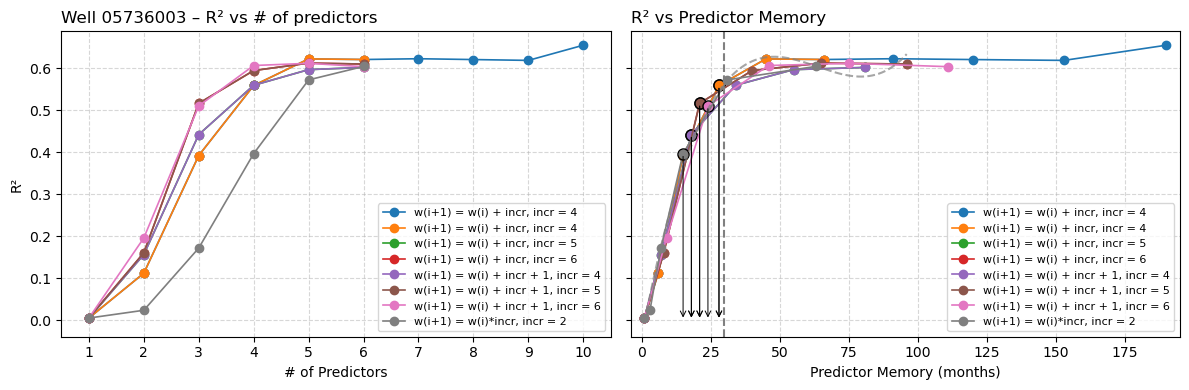


LR models Finished! 
Finito! 
Terminado!



In [93]:
#### OLD #####

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


# === Load R2 results for all model configurations ===
root = '/Users/cag/Dropbox/0_Research/A_Fondecyts/2024_CAG_Ini_11240924/fdcyt_cag_GW_analysis/Analysis_cag_mid'
out_figs = root + '/2_GW_memory'

# === Output folder ===
out_dir = out_figs + '/memory_per_well'
os.makedirs(out_dir, exist_ok=True)

# === Parameters ===
perc_max_r2 = 0.9  # percent of max R2 to consider
tolerance = 0.02   # accepted drop from threshold

# === Load and filter data ===
df = pd.read_csv(f"{out_figs}/r2_summary_all.csv", dtype={"well_id": str})
df = df[df['well_id']=='05736003']

# === Build dynamic model_configs ===
model_configs = {}
for name in df['model_config'].unique():
    subset = df[df['model_config'] == name].iloc[0]
    
    # Parse lag_type and lag_increase from lag_type string or other columns
    lt = int(name.split('_')[0].replace('type', ''))
    li = int(name.split('_')[1].replace('incr', ''))
    npmax = subset['n_pred'] if 'n_pred' in subset else df[df['model_config'] == name]['n_pred'].max()

    model_configs[name] = (lt, li, int(npmax))

# === Assign colors dynamically
color_palette = plt.get_cmap('tab10')  # or 'tab20', 'Set2', etc.
model_colors = {
    name: color_palette(i % 10)
    for i, name in enumerate(model_configs.keys())
}


selected_configs = [
    # {"n_pred_max":10, "lag_type": 1, "lag_increase": 4, "model_config": 'type1_incr4_pred10_max'},
    {"n_pred_max":6,  "lag_type": 1, "lag_increase": 4, "model_config": 'type1_incr4_pred6_max'},
    {"n_pred_max":6,  "lag_type": 2, "lag_increase": 4, "model_config": 'type2_incr4_pred6_max'},
    {"n_pred_max":6,  "lag_type": 3, "lag_increase": 2, "model_config": 'type3_incr2_pred6_max'},
    {"n_pred_max":6,  "lag_type": 1, "lag_increase": 5, "model_config": 'type1_incr5_pred6_max'},
    {"n_pred_max":6,  "lag_type": 2, "lag_increase": 5, "model_config": 'type2_incr5_pred6_max'},
    # {"n_pred_max":6,  "lag_type": 3, "lag_increase": 3, "model_config": 'type3_incr3_pred6_max'}
]

selected_labels = [c["model_config"] for c in selected_configs]

# === Compute hydro memory ===
results = []
for config_label in model_configs.keys():
    df_config = df[df['model_config'] == config_label].copy()

    for well, group in df_config.groupby('well_id'):
        group_sorted = group.sort_values('n_pred', ascending=False)
        max_r2 = group_sorted['r2'].max()

        if pd.isna(max_r2):
            results.append({'well_id': well, 
                            'model_config': config_label, 
                            'max_r2': np.nan, 
                            'memory_80pct_rmax': np.nan})
            continue

        threshold = perc_max_r2 * max_r2
        group_below_threshold = group_sorted[group_sorted['r2'] < (threshold)]

        memory = np.nan
        if not group_below_threshold.empty:
            best_row = group_below_threshold.sort_values('n_pred', ascending=False).iloc[0]
            memory = best_row['pred_memory']
            
        # if config_label == 'type1_incr4_pred6_max' and well == df['well_id'].unique()[-1]:
        #     print(f"\n🔍 DEBUG STOP at well {well} and config {config_label}")
        #     debug_group = group_below_threshold.copy()
        #     debug_memory = memory.copy()
        #     breakpoint()

        results.append({'well_id': well, 
                        'model_config': config_label, 
                        'max_r2': max_r2, 
                        'memory_80pct_rmax': memory})

df_memory = pd.DataFrame(results)

# === Plot for each well ===
for well in df['well_id'].unique():
    well_data = df[df['well_id'] == well]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # Loop only over configs available in data
    for name in sorted(well_data['model_config'].unique()):
        if name not in model_configs:
            continue  # Skip configs not in main dict

        lt, li, npmax = model_configs[name]
        lag_type_str = f'type{lt}_incr{li}'
        valid_models = [f'{lag_type_str}_pred{n}' for n in range(1, npmax + 1)]
        subset = well_data[well_data['lag_type'].isin(valid_models)].sort_values('n_pred')

        if not subset.empty:
            model_type = subset['lag_incr_rule'].unique()[0]
            label = f"{model_type}, incr = {li}"
            color = model_colors.get(name, 'gray')

            ax1.plot(
                subset['n_pred'], subset['r2'],
                label=label, marker='o', linewidth=1.2, color=color
            )

            ax2.plot(
                subset['pred_memory'], subset['r2'],
                label=label, marker='o', linewidth=1.2, color=color
            )

            memory_val = df_memory[
                (df_memory['well_id'] == well) &
                (df_memory['model_config'] == name)
            ]['memory_80pct_rmax'].values

            if len(memory_val) > 0 and not pd.isna(memory_val[0]):
                mem_x = memory_val[0]
                mem_y = subset[subset['pred_memory'] == mem_x]['r2'].values
                if len(mem_y) > 0:
                    ax2.plot(
                        mem_x, mem_y[0],
                        marker='o', markersize=8,
                        markerfacecolor='none',
                        markeredgecolor='black',
                        label=None
                    )
                    ax2.annotate(
                        '', xy=(mem_x, mem_y[0]), xytext=(mem_x, 0),
                        arrowprops=dict(arrowstyle='<-', color='black', linewidth=0.7)
                    )

    ax1.set_title(f"Well {well} – R² vs # of predictors", loc='left')
    ax1.set_xlabel("# of Predictors")
    ax1.set_ylabel("R²")
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.legend(fontsize=8)
    ax1.set_xlim(0.5, 10.5)
    ax1.set_xticks(range(1, 11))

    ax2.set_title("R² vs Predictor Memory", loc='left')
    ax2.set_xlabel("Predictor Memory (months)")
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.legend(fontsize=8)
    ax2.set_xlim(df['pred_memory'].min() - 5, df['pred_memory'].max() + 5)

    
    well_data_spline = well_data[well_data['model_config'].isin(selected_labels)]
    mem_curve, x_spline, y_spline = compute_memory_from_spline(well_data_spline)

    if not np.isnan(mem_curve):
        ax2.axvline(mem_curve, linestyle='--', color='gray', label='Curve-based memory')
        ax2.plot(x_spline, y_spline, linestyle='--', color='gray', alpha=0.7)
            
    plt.tight_layout()
    plt.show()
    
    # plt.savefig(f"{out_dir}/memory_{well}.pdf", bbox_inches='tight')
    # plt.close()
    
print("\nLR models Finished! \nFinito! \nTerminado!\n")

In [70]:
selected_configs

selected_labels = [c["model_config"] for c in selected_configs]

selected_labels
# selected_configs["model_config"]

['type1_incr4_pred6_max',
 'type2_incr4_pred6_max',
 'type3_incr2_pred6_max',
 'type1_incr5_pred6_max',
 'type2_incr5_pred6_max']

In [28]:
results

[{'well_id': '01700105',
  'model_config': 'type1_incr4_pred10_max',
  'max_r2': 0.6173242020186781,
  'memory_80pct_rmax': 153},
 {'well_id': '03451008',
  'model_config': 'type1_incr4_pred10_max',
  'max_r2': 0.437942112202599,
  'memory_80pct_rmax': 153}]